In [1]:
import cv2
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import socket
import sys

from keras.models import load_model, Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten, TimeDistributed, Dropout, Input
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [5]:
path = "data2"
images = []
classNo = []
testRatio = 0.2
batchSizeVal = 48
stepsPerEpochVal = 200
epochsVal = 50
valRatio = 0.2
imageDimensions = (32, 32, 3)

In [6]:
myList = os.listdir(path)
print(len(myList))
noOfClasses = len(myList)
for x in range(0, noOfClasses):
    myPicList = os.listdir(path+"/"+myList[x])
    for y in myPicList:
        # split the file path into base name and extension
        base_name, extension = os.path.splitext(y)
        if extension == '.jpg' and extension != '.db':
            curImg = cv2.imread(path+"/"+myList[x]+"/"+y, cv2.IMREAD_COLOR)
        # check if the extension matches '.tif'
        elif extension == '.tif' and extension != '.db':
            curImg = cv2.imread(path+"/"+myList[x]+"/"+y, cv2.IMREAD_UNCHANGED)
            # Convert the image to JPEG format
            cv2.imwrite(path+"/"+myList[x]+"/"+base_name+'.jpg',
                        curImg, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
            curImg = cv2.imread(
                path+"/"+myList[x]+"/"+base_name+'.jpg', cv2.IMREAD_COLOR)
        elif extension == '.bmp' and extension != '.db':
            curImg = cv2.imread(path+"/"+myList[x]+"/"+y)
        curImg = cv2.resize(curImg, (imageDimensions[0], imageDimensions[1]))
        images.append(curImg)
        classNo.append(x)
    # print(x)
print(len(images))

62
26456


In [7]:
images = np.array(images)
classNo= np.array(classNo)

# numOfSamples = []
# for x in range(0,noOfClasses):
#    # #It is giving us for each class how many images do we have
#     numOfSamples.append(len(np.where(y_train==x)[0]))
# print(numOfSamples)  

In [8]:
# plt.figure(figsize=(10,5))
# plt.bar(range(0,noOfClasses),numOfSamples)
# plt.title("No of Images for each class")
# plt.xlabel("Class ID")
# plt.ylabel("Number of Images")
# plt.show()

In [9]:
classNo = classNo.reshape(-1, 1)
noOfClasses = classNo
onehotencoder = OneHotEncoder()
Y = onehotencoder.fit_transform(classNo).toarray()

images, Y = shuffle(images, Y, random_state=69)

x_train, x_test, y_train, y_test = train_test_split(
    images, Y, test_size=testRatio, random_state=69)
x_train, x_validation, y_train, y_validation = train_test_split(
    x_train, y_train, test_size=valRatio, random_state=69)

print(x_train.shape)
print(x_test.shape)
print(x_validation.shape)


(16931, 32, 32, 3)
(5292, 32, 32, 3)
(4233, 32, 32, 3)


In [22]:
# def preProcessing(img):
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     img = cv2.equalizeHist(img)
#     img = img/255
#     return img

In [10]:
def VGG16(input_shape, num_classes):
    # Input layer
    inputs = Input(shape=input_shape)

    # Convolutional layers
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Flatten layer
    x = Flatten()(x)

    # Fully connected layers
    x = Dense(4096, activation='relu')(x)
    x = Dense(4096, activation='relu')(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    return model


In [24]:
# x_train = np.array(list(map(preProcessing, x_train)))
# x_test = np.array(list(map(preProcessing, x_test)))
# x_validation = np.array(list(map(preProcessing, x_validation)))

# x_train = x_train.reshape(
#     x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
# x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
# x_validation = x_validation.reshape(
#     x_validation.shape[0], x_validation.shape[1], x_validation.shape[2], 1)

# y_train = to_categorical(y_train, noOfClasses)
# y_test = to_categorical(y_test, noOfClasses)
# y_validation = to_categorical(y_validation, noOfClasses)

In [25]:
# dataGen = ImageDataGenerator(width_shift_range=0.1,
#                              height_shift_range=0.1,
#                              zoom_range=0.2,
#                              shear_range=0.1,
#                              rotation_range=10)
# dataGen.fit(x_train)

In [11]:
# Set the input shape and number of classes
input_shape = (32,32, 3)  # Adjust according to your dataset
num_classes = 62  # Adjust according to your dataset

# Create an instance of the VGG16 model
model = VGG16(input_shape, num_classes)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       147584    
                                                             

In [12]:
# Calculate class weights based on the distribution of the training set
class_weights = {}
unique, counts = np.unique(classNo, return_counts=True)
total = np.sum(counts)
for i in range(len(unique)):
    class_weights[unique[i]] = total / (len(unique) * counts[i])

In [13]:
class_weights

{0: 1.6475277120438412,
 1: 1.1919264732384214,
 2: 0.9440479588923779,
 3: 0.950355628996336,
 4: 0.9461411916171948,
 5: 0.9482437275985663,
 6: 0.9419639678131453,
 7: 0.9440479588923779,
 8: 0.9419639678131453,
 9: 0.950355628996336,
 10: 0.9461411916171948,
 11: 0.9461411916171948,
 12: 0.838329425185373,
 13: 0.9461411916171948,
 14: 0.9461411916171948,
 15: 0.9482437275985663,
 16: 0.9461411916171948,
 17: 0.9461411916171948,
 18: 0.9461411916171948,
 19: 0.9461411916171948,
 20: 0.9419639678131453,
 21: 0.9482437275985663,
 22: 0.9461411916171948,
 23: 0.8205955334987594,
 24: 0.950355628996336,
 25: 0.9482437275985663,
 26: 0.9461411916171948,
 27: 0.950355628996336,
 28: 0.9461411916171948,
 29: 0.9440479588923779,
 30: 0.9419639678131453,
 31: 0.9461411916171948,
 32: 0.9482437275985663,
 33: 0.9482437275985663,
 34: 0.838329425185373,
 35: 0.9419639678131453,
 36: 0.9482437275985663,
 37: 0.9524769585253456,
 38: 0.9461411916171948,
 39: 0.9440479588923779,
 40: 0.948243727

In [14]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_validation, y_validation),
                    shuffle=1,
                    class_weight=class_weights)

Epoch 1/10
322/530 [=================>............] - ETA: 3:04 - loss: 6.6685 - accuracy: 0.0110

KeyboardInterrupt: 

In [30]:
score = model.evaluate(x_test,y_test,verbose=0)
print('Test Loss Score = ',score[0])
print('Test Accuracy = ',score[1])

Test Loss Score =  0.8426890969276428
Test Accuracy =  0.7490552067756653


In [31]:
# Saving the model
pickle_out = open("model_trained_iitbbsv2.p", "wb")
pickle.dump(model, pickle_out)
pickle_out.close()

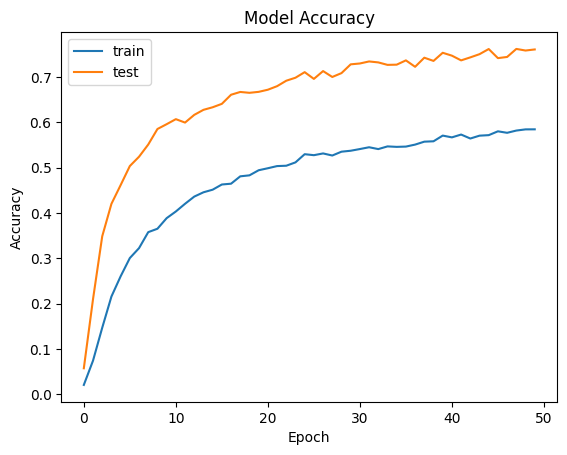

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()